In [2]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.7 MB/s eta 0:00:00


In [3]:
'''
Importing Libraries
'''
import torch
import torch.nn as nn
from torch.nn import functional as F
from torcheval.metrics.functional import bleu_score
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
import math
import random
import os
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from sklearn.model_selection import train_test_split


In [4]:
'''
Model Hyper-parameters
'''

n_emb = 256
vocab_size = 30000
seq_len = 64
batch_size = 64
num_heads = 4
n_dropout = 0.1
ffwd_w = 1024
num_sa_blocks = 4
num_ca_blocks = 4


torch.manual_seed(1234)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [6]:
'''
Tokenization
'''

tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()

# trainer defination
trainer = trainers.BpeTrainer(
    vocab_size=vocab_size,
    special_tokens=["[START]", "[END]", "[PAD]"]
)

tokenizer.train(files=['sample_data/source_train.txt', 'sample_data/target_train.txt'], trainer=trainer)
tokenizer.save("tokenizer.json")

In [7]:
'''
Opening Files and Embedding Vector
'''
def load_lines(file_path, limit=None):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    lines = [l.strip() for l in lines]
    if limit:
        lines = lines[:limit]
    return lines

trn_src = load_lines('sample_data/source_train.txt', limit=500000)
trn_tgt = load_lines('sample_data/target_train.txt', limit=500000)

val_src = load_lines('sample_data/source_valid.txt')
val_tgt = load_lines('sample_data/target_valid.txt')

# embedding layer
embeds = nn.Embedding(vocab_size, n_emb, device=device)

# Print lengths to verify
print(len(trn_src), len(trn_tgt), len(val_src), len(val_tgt))
print(trn_src[0])
print(trn_tgt[0])


222312 222312 55579 55579
Tom's bedtime is nine o'clock on school nights.
Wenn Schule ist, beginnt Toms Schlafenszeit um neun Uhr.


In [8]:
def get_tensor(token_id, tokenizer, embeds, pos_encoder, device):
    token_id = torch.tensor(token_id, device=device)
    emb_token = embeds(token_id).to(device)
    emb_token = emb_token.view(1, 1, -1)
    emb_token = pos_encoder(emb_token, seq_len=1)
    return emb_token

In [9]:
# this is Input Embedings and positional encoding
def get_tensor_for_inf_x(x, tokenizer, embeds, pos_encoder, seq_len, n_emb, device):
    
    
    # Encoding start end
    tokens = tokenizer.encode(x).tokens
    tokens.insert(0, "[START]")
    tokens.append("[END]")



    if len(tokens) > seq_len:
        raise ValueError(f"Input is too long: {len(tokens)} tokens, max is {seq_len}")

    # paddind end 
    while len(tokens) < seq_len:
        tokens.append("[PAD]")
        
        
    # tokens = ["[START]", "good", "morning", "[END]", "[PAD]"]
    # token_ids = [1, 345, 678, 2, 0]

    token_ids = [tokenizer.token_to_id(t) for t in tokens]
    t_tokens = torch.tensor(token_ids, dtype=torch.long, device=device)

    # Adds an extra dimension at position 0 
    t_embs = embeds(t_tokens).unsqueeze(0) 
    t_embs = pos_encoder(t_embs)

    return t_embs


In [10]:

def get_batch(transformer, split="train", batch_size=16, seq_len=64):
    # Select dataset
    inp_data = trn_src if split == "train" else val_src
    out_data = trn_tgt if split == "train" else val_tgt

    # Initialize tensors
    inp_btc = torch.zeros(batch_size, seq_len, transformer.n_emb, device=transformer.device)
    out_btc = torch.zeros(batch_size, seq_len, transformer.n_emb, device=transformer.device)
    target = torch.empty(batch_size, seq_len, dtype=torch.long, device=transformer.device)

    for i in range(batch_size):
        # Get random sentence pair that fits sequence length
        while True:
            idx = random.randint(0, len(inp_data) - 1)
            inp = inp_data[idx]
            out = out_data[idx]

            inp_tokens = transformer.tokenizer.encode(inp).tokens
            out_tokens = transformer.tokenizer.encode(out).tokens

            inp_tokens = ["[START]"] + inp_tokens + ["[END]"]
            out_tokens = ["[START]"] + out_tokens + ["[END]"]

            if len(inp_tokens) <= seq_len and len(out_tokens) <= seq_len:
                break

        # Pad sequences to seq_len
        inp_tokens += ["[PAD]"] * (seq_len - len(inp_tokens))
        out_tokens += ["[PAD]"] * (seq_len - len(out_tokens))

        # Prepare decoder input and target
        dec_inp = out_tokens[:-1]
        target_tokens = out_tokens[1:]

        dec_inp += ["[PAD]"] * (seq_len - len(dec_inp))
        target_tokens += ["[PAD]"] * (seq_len - len(target_tokens))

        # Convert tokens to IDs
        inp_ids = [transformer.tokenizer.token_to_id(tok) for tok in inp_tokens]
        dec_ids = [transformer.tokenizer.token_to_id(tok) for tok in dec_inp]
        tgt_ids = [transformer.tokenizer.token_to_id(tok) for tok in target_tokens]

        # Convert to tensors
        t_inp = torch.tensor(inp_ids, dtype=torch.long, device=transformer.device)
        t_dec = torch.tensor(dec_ids, dtype=torch.long, device=transformer.device)
        t_tgt = torch.tensor(tgt_ids, dtype=torch.long, device=transformer.device)

        # Store target labels
        target[i] = t_tgt

        # Embed and apply positional encoding
        inp_emb = transformer.pos_encoder(transformer.embeds(t_inp).unsqueeze(0)).squeeze(0)
        dec_emb = transformer.pos_encoder(transformer.embeds(t_dec).unsqueeze(0)).squeeze(0)

        # Store embeddings in batch
        inp_btc[i] = inp_emb
        out_btc[i] = dec_emb

    return inp_btc, out_btc, target


In [ ]:

count = 0
for sen in trn_src:
    inp_tokens = tokenizer.encode(sen).tokens
    inp_tokens.insert(0, "[START]")
    inp_tokens.append("[END]")

    if len(inp_tokens) <= 64:
        count += 1

print(count)

In [30]:
count = 0
for sen in trn_tgt:
    inp_tokens = tokenizer.encode(sen).tokens
    inp_tokens.insert(0, "[START]")
    inp_tokens.append("[END]")

    if len(inp_tokens) <= 64:
        count += 1

print(count)

222308


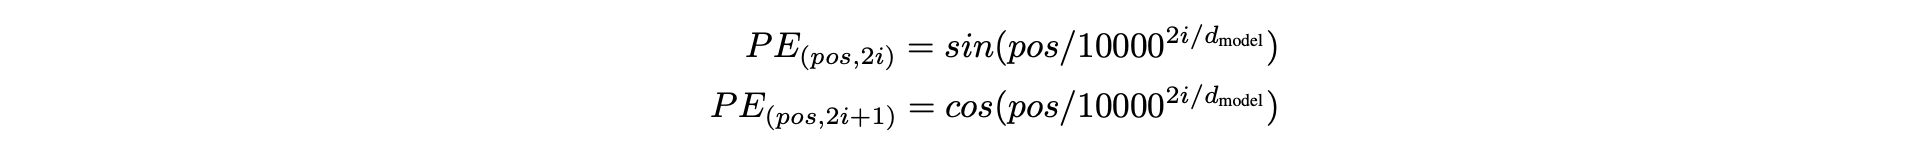

In [11]:
'''
Positional Embedding
'''

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=512, device='cuda'):
        super().__init__()
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        self.device = device

        pe = torch.zeros(max_seq_length, d_model, device=device)
        position = torch.arange(0, max_seq_length, dtype=torch.float, device=device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() * (-math.log(10000.0) / d_model))
         
        # even
        pe[:, 0::2] = torch.sin(position * div_term)
        # odd
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x, seq_len=None):
        if seq_len is None:
            seq_len = x.size(1)
        return x + self.pe[:seq_len, :].unsqueeze(0)


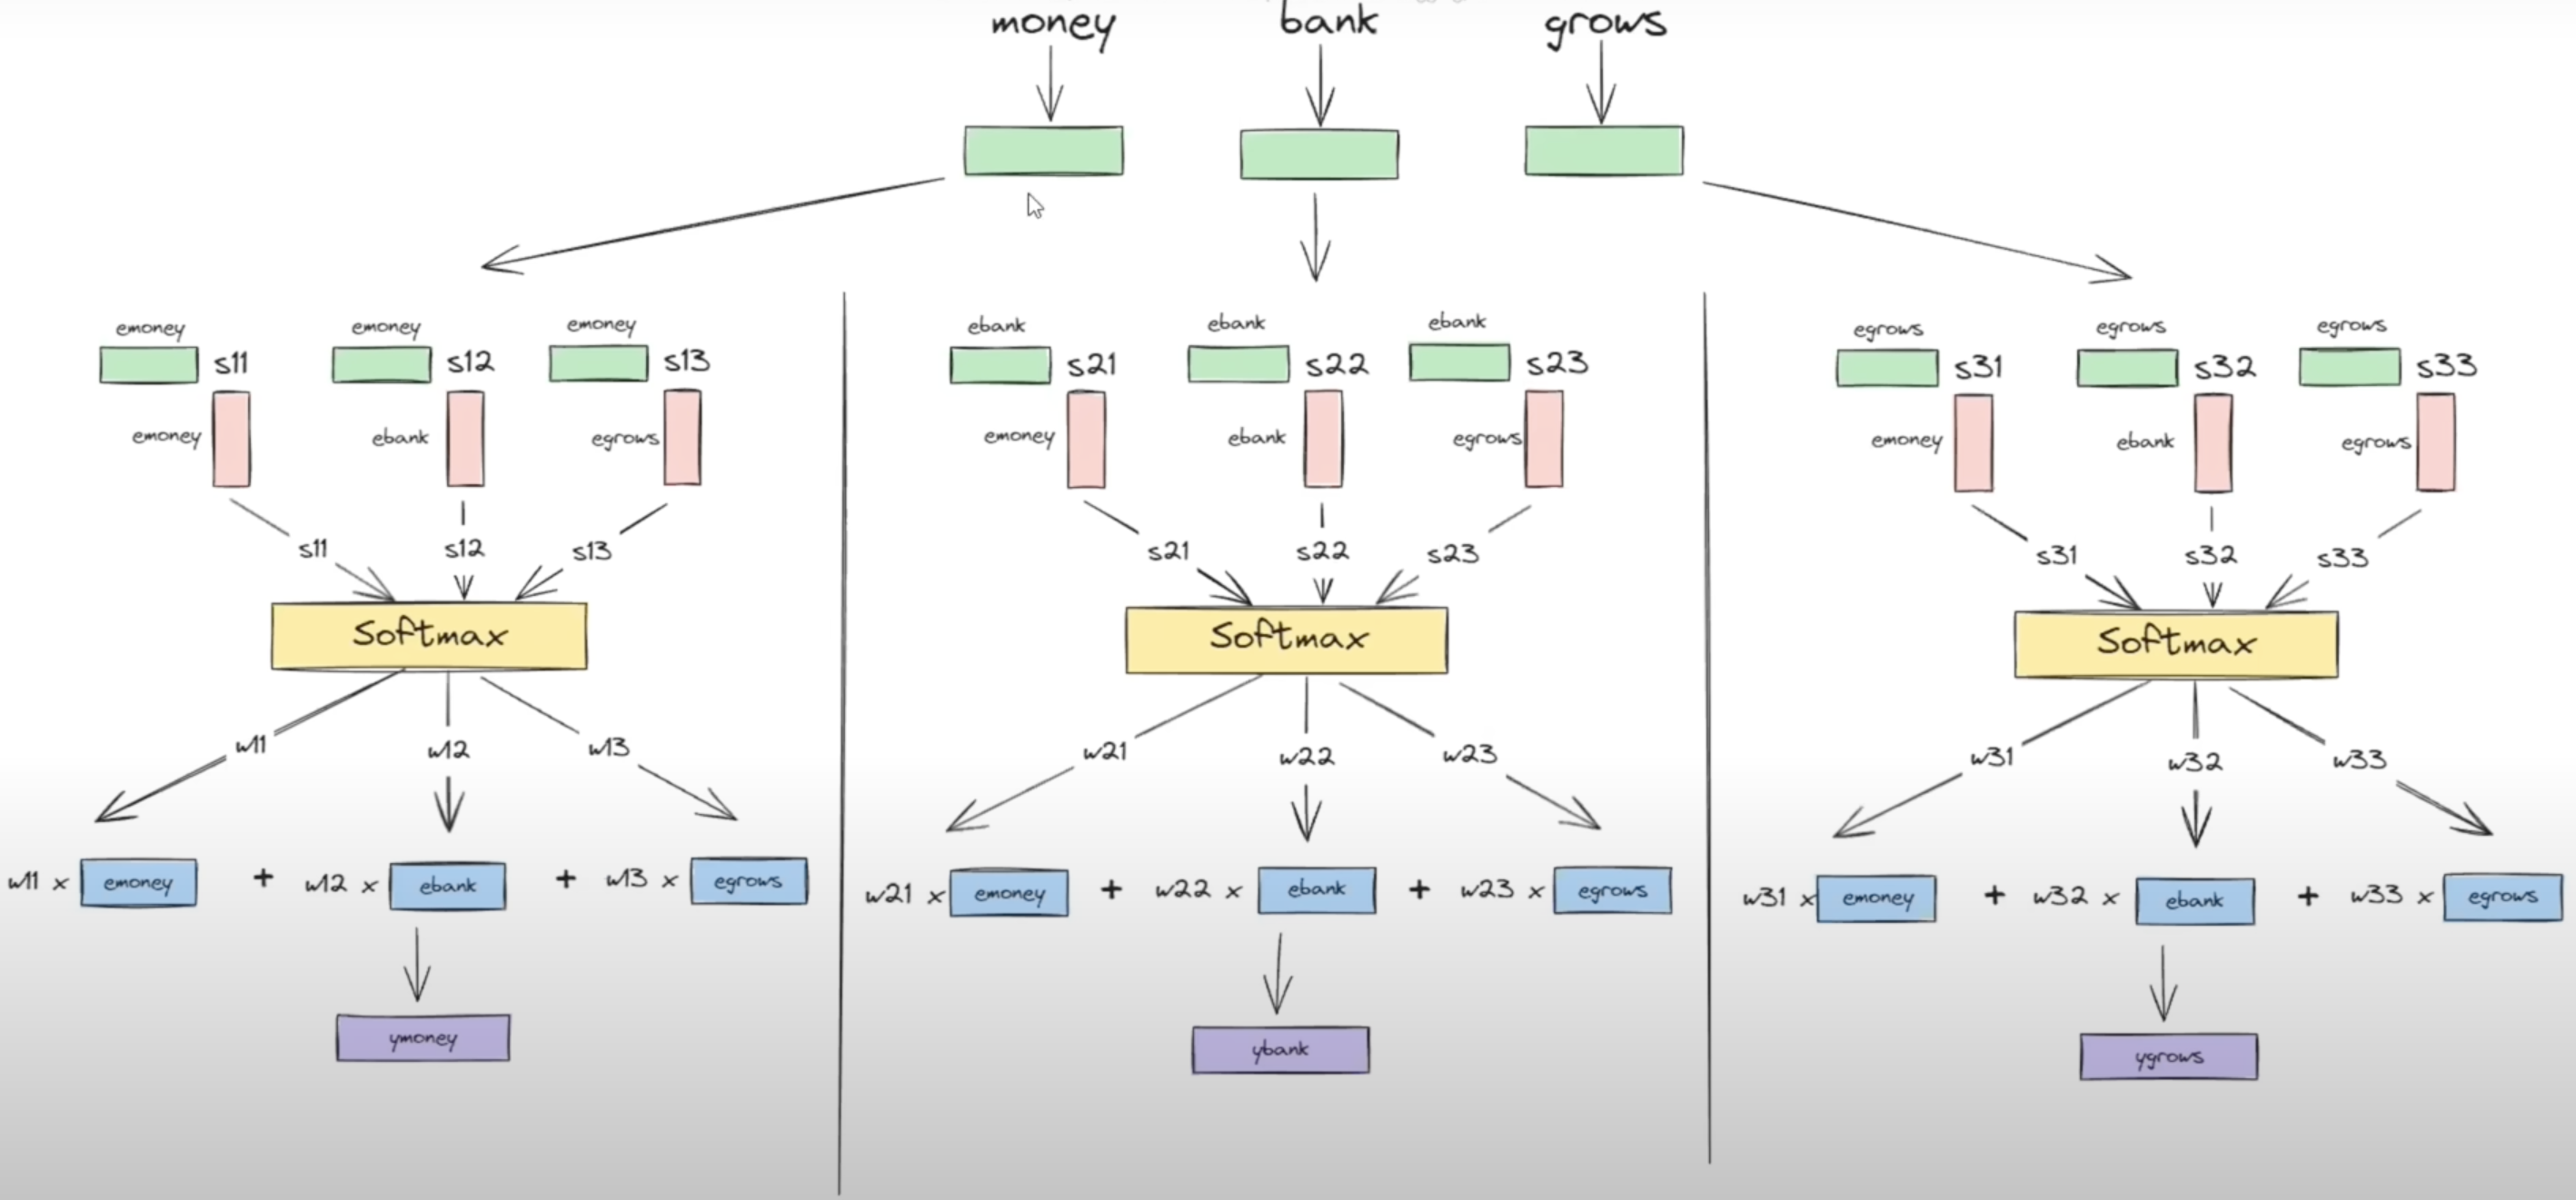

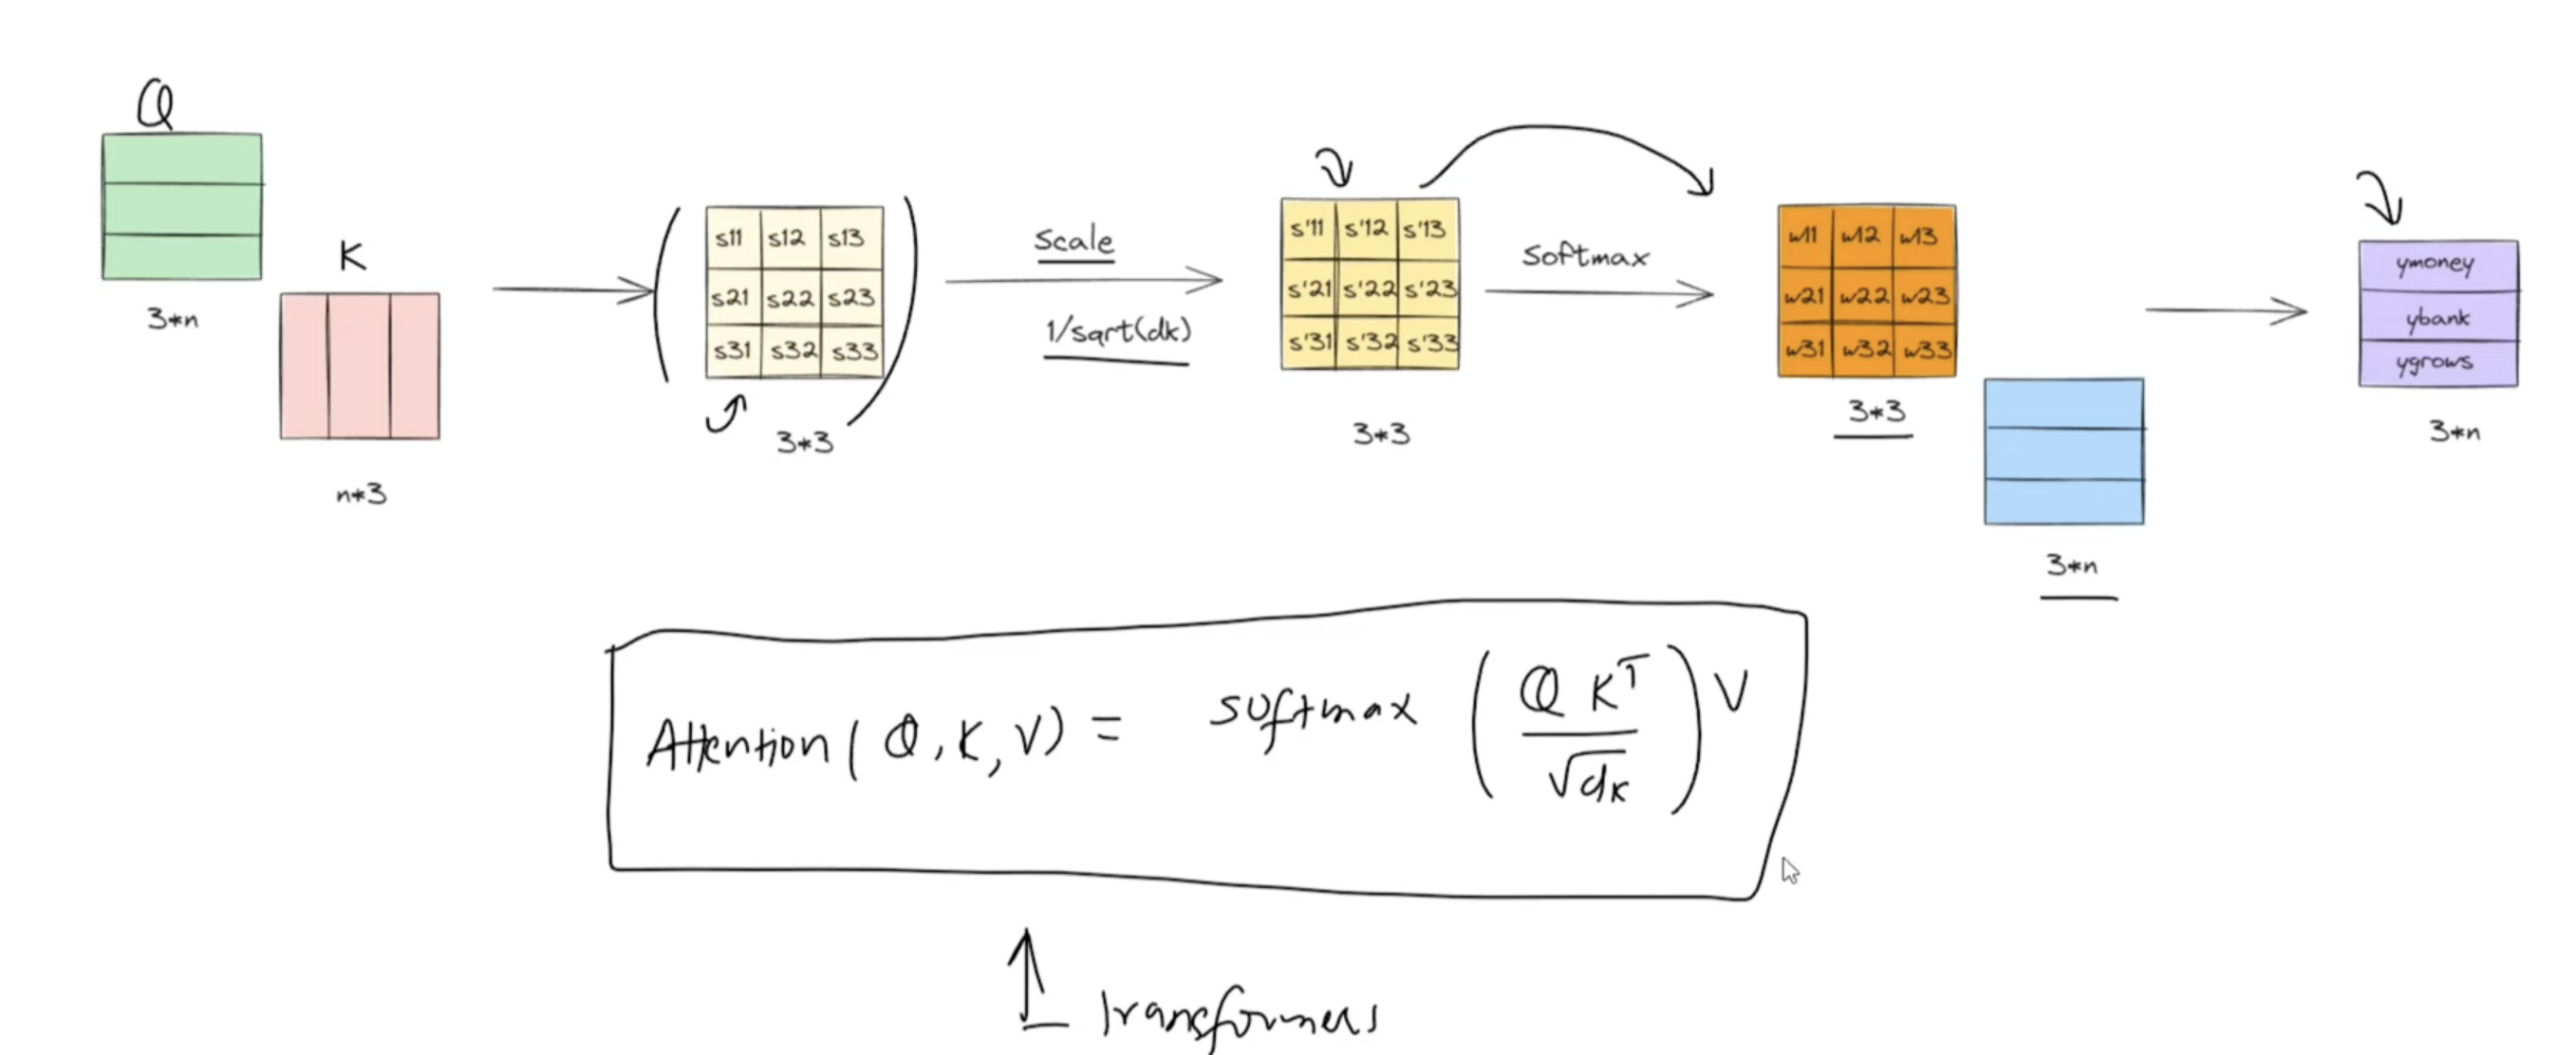

In [12]:
'''
Encoder
'''

class SA_Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()

        self.wk = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.wq = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.wv = nn.Linear(n_emb, head_size, bias=False, device=device)

    def forward(self, ini_emb):
        k = self.wk(ini_emb)
        q = self.wq(ini_emb)
        v = self.wv(ini_emb)

        k_mul = q @ k.transpose(-2, -1)
        # dividing by 1/root(d)
        scaling = k_mul * (n_emb**-0.5)
        sm_mul = F.softmax(scaling, dim=-1)
        v_mul = sm_mul @ v

        return v_mul


class SA_MultiHead(nn.Module):
    def __init__(self):
        super().__init__()

        # 256 // 4 = 64 → each SA_Head outputs 64-dim vectors
        self.head_size = n_emb // num_heads
        self.heads = nn.ModuleList([SA_Head(self.head_size) for _ in range(num_heads)])
        self.lyr = nn.Linear(n_emb, n_emb, bias=False, device=device)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.lyr(out)

        return out

class SA_Block(nn.Module):
    def __init__(self):
        super().__init__()

        self.mh_atn = SA_MultiHead()
        self.dropout = nn.Dropout(n_dropout)
        self.ln1 = nn.LayerNorm(n_emb, device=device)
        self.ln2 = nn.LayerNorm(n_emb, device=device)
        self.ffwd = nn.Sequential(
                nn.Linear(n_emb, ffwd_w, device=device),
                nn.ReLU(),
                nn.Linear(ffwd_w, n_emb, device=device)
                )

    def forward(self, x):
        out = self.ln1(x)
        out = self.mh_atn(out)
        out = self.dropout(out)
        out = out + x
        out1 = self.ln2(out)
        out1 = self.ffwd(out1)
        out1 = out1 + out
        return out1


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.sa_blocks_list = []

        for _ in range(num_sa_blocks):
            self.sa_blocks_list.append(SA_Block())

        self.sa_blocks = nn.Sequential(*self.sa_blocks_list)

    def forward(self, x):
        out = self.sa_blocks(x)

        return out


In [13]:
'''
Decoder
'''

class MA_Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()

        self.kw = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.qw = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.vw = nn.Linear(n_emb, head_size, bias=False, device=device)

    def forward(self, x):
        k = self.kw(x)
        q = self.qw(x)
        v = self.vw(x)
        mask = torch.triu(torch.full((x.size(1), x.size(1)), float('-inf'), device=device), diagonal=1)
        out = q @ k.transpose(-2, -1)
        out = out * (n_emb  ** -0.5)
        out = out + mask
        out = F.softmax(out, dim=-1)
        out = out @ v

        return out

class MA_MultiHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.head_size = n_emb // num_heads
        self.heads = nn.ModuleList([MA_Head(self.head_size) for _ in range(num_heads)])
        self.lyr = nn.Linear(n_emb, n_emb, bias=False, device=device)


    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.lyr(out)

        return out

class CA_Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()

        self.head_size = head_size
        self.kw = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.qw = nn.Linear(n_emb, head_size, bias=False, device=device)
        self.vw = nn.Linear(n_emb, head_size, bias=False, device=device)

    def forward(self, x_enc, x_dec):
        q = self.qw(x_dec)
        k = self.kw(x_enc)
        v = self.vw(x_enc)

        out = q @ k.transpose(-2, -1)
        out = out * (n_emb ** -0.5)
        out = F.softmax(out, dim=-1)
        out = out @ v

        return out


class CA_MultiHead(nn.Module):
    def __init__(self, ):
        super().__init__()

        self.head_size = n_emb // num_heads
        self.heads = nn.ModuleList([CA_Head(self.head_size) for _ in range(num_heads)])
        self.lyr = nn.Linear(n_emb, n_emb, bias=False, device=device)


    def forward(self, x_enc, x_dec):
        out = torch.cat([h(x_enc, x_dec) for h in self.heads], dim=-1)
        out = self.lyr(out)

        return out


class CA_Block(nn.Module):
    def __init__(self):
        super().__init__()

        self.mmh_attn = MA_MultiHead()
        self.do_1 = nn.Dropout(n_dropout)
        self.cah_attn = CA_MultiHead()
        self.do_2 = nn.Dropout(n_dropout)
        self.ffwd = nn.Sequential(
                nn.Linear(n_emb, ffwd_w, device=device),
                nn.ReLU(),
                nn.Linear(ffwd_w, n_emb, device=device)
                )

        self.ln1 = nn.LayerNorm(n_emb, device=device)
        self.ln2 = nn.LayerNorm(n_emb, device=device)
        self.ln3 = nn.LayerNorm(n_emb, device=device)

    def forward(self, x_enc, x_dec):
        out = self.ln1(x_dec)
        out = self.mmh_attn(out)
        out = self.do_1(out)
        out = out + x_dec  # residual

        out1 = self.ln2(out)
        out1 = self.cah_attn(x_enc, out1)
        out1 = self.do_2(out1)
        out1 = out1 + out  # residual

        out2 = self.ln3(out1)
        out2 = self.ffwd(out2)
        out2 = out2 + out1  # residual

        return out2

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.ca_blocks_list = []

        for _ in range(num_ca_blocks):
            self.ca_blocks_list.append(CA_Block())

        self.ca_blocks = nn.ModuleList(self.ca_blocks_list)

        self.lyr = nn.Linear(n_emb, vocab_size, device=device)

    def forward(self, x_enc, x_dec, split="training"):
        # if purp == "training":
        for block in self.ca_blocks:
            x_dec = block(x_enc, x_dec)

        '''
        Final Layer
        '''
        if split == "training":
          logits = self.lyr(x_dec)
          out = F.softmax(logits, dim=-1)
          out = torch.argmax(out, dim=-1)

        if split == "inference":
          logits = self.lyr(x_dec[:, -1, :])
          out = F.softmax(logits, dim=-1)
          out = torch.argmax(out, -1)

        return logits, out



In [14]:
'''
 Transformer Class
'''
class Transformer(nn.Module):
    def __init__(self, vocab_size, n_emb, seq_len, device, tokenizer):
        super().__init__()

        self.pos_encoder = PositionalEncoding(n_emb, seq_len, device)
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.embeds = nn.Embedding(vocab_size, n_emb, device=device)
        self.tokenizer = tokenizer

        self.seq_len = seq_len
        self.n_emb = n_emb
        self.device = device

    def forward(self, x_enc, x_dec, targets=None):
        res_enc = self.encoder(x_enc)
        logits, out = self.decoder(res_enc, x_dec)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=self.tokenizer.token_to_id("[PAD]"))

        return logits, loss

    def get_batch(self, split="train", batch_size=16):
        return get_batch(self, split, batch_size, self.seq_len)

    def predict(self, x, max_len=50):
        x_dec = get_tensor(
            self.tokenizer.token_to_id("[START]"),
            self.tokenizer,
            self.embeds,
            self.pos_encoder,
            self.device
        )

        inp_embs = get_tensor_for_inf_x(
            x,
            self.tokenizer,
            self.embeds,
            self.pos_encoder,
            self.seq_len,
            self.n_emb,
            self.device
        )

        res_enc = self.encoder(inp_embs)
        final_sentence = []

        while len(final_sentence) < max_len:
            logits, out = self.decoder(res_enc, x_dec, split="inference")
            final_token = self.tokenizer.id_to_token(out[-1])

            if final_token == "[END]":
                break

            final_sentence.append(final_token)

            new_embed = get_tensor(
                out[-1],
                self.tokenizer,
                self.embeds,
                self.pos_encoder,
                self.device
            )

            x_dec = torch.cat([x_dec, new_embed], dim=1)

        return " ".join(final_sentence)


In [15]:
def train_step(transformer, optimizer):
    # Get batch
    inp_btc, out_btc, targets = transformer.get_batch("train")

    # Forward pass
    logits, loss = transformer(inp_btc, out_btc, targets)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [16]:
# Training loop example
def train_transformer(transformer, lr, epochs=10):
    optimizer = torch.optim.AdamW(transformer.parameters(), lr=lr, betas=(0.9, 0.98), weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1000, T_mult=1, eta_min=1e-6)


    for epoch in range(epochs):
        transformer.train()
        train_losses = []

        num_steps = len(trn_src) // batch_size
        eval_interval = num_steps // 10

        for step in range(num_steps):
            # loss = train_step(transformer, optimizer)
            inp_btc, out_btc, targets = transformer.get_batch("train")

            # Forward pass
            logits, loss = transformer(inp_btc, out_btc, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            train_losses.append(loss.item())

            if step % eval_interval == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch: {epoch+1} \t | step: {step} \t | lr: {current_lr} \t | loss: {loss:.4f}")

        transformer.eval()
        test_losses = []
        for _ in range(100):
            with torch.no_grad():
                inp_btc, out_btc, targets = transformer.get_batch("test")
                _, eval_loss = transformer(inp_btc, out_btc, targets)
                test_losses.append(eval_loss.item())

        avg_trn_loss = sum(train_losses) / len(train_losses)
        avg_tst_loss = sum(test_losses) / len(test_losses)

        print("--------------------------------------")
        print(f"Epoch {epoch+1} summary")
        print(f"Avg Train loss: {avg_trn_loss}")
        print(f"Avg Test loss: {avg_tst_loss}")
        print("--------------------------------------")

In [17]:
transformer = Transformer(
    vocab_size=vocab_size,
    n_emb=n_emb,
    seq_len=seq_len,
    device=device,
    tokenizer=tokenizer
)

In [18]:
trans_params = sum(p.numel() for p in transformer.parameters())
print(f"\n Total Parameters = {trans_params}\n")

# Train the model
train_transformer(transformer, 3e-4, 10)



 Total Parameters = 22750512

Epoch: 1 	 | step: 0 	 | lr: 0.0002999992622476778 	 | loss: 10.6716
Epoch: 1 	 | step: 347 	 | lr: 0.00021920718916291243 	 | loss: 6.6774
Epoch: 1 	 | step: 694 	 | lr: 6.453671481952984e-05 	 | loss: 5.6903
Epoch: 1 	 | step: 1041 	 | lr: 0.0002987004908448912 	 | loss: 4.9665
Epoch: 1 	 | step: 1388 	 | lr: 0.0002015829701297767 	 | loss: 4.8856
Epoch: 1 	 | step: 1735 	 | lr: 4.953774518590683e-05 	 | loss: 4.4700
Epoch: 1 	 | step: 2082 	 | lr: 0.0002949463515266163 	 | loss: 5.5061
Epoch: 1 	 | step: 2429 	 | lr: 0.0001831124145887831 	 | loss: 4.5493
Epoch: 1 	 | step: 2776 	 | lr: 3.621150605224784e-05 	 | loss: 4.4871
Epoch: 1 	 | step: 3123 	 | lr: 0.00028879904242175145 	 | loss: 5.2224
Epoch: 1 	 | step: 3470 	 | lr: 0.00016410154048358366 	 | loss: 4.0392
--------------------------------------
Epoch 1 summary
Avg Train loss: 5.0827928327395115
Avg Test loss: 4.516445455551147
--------------------------------------
Epoch: 2 	 | step: 0 	 | lr

In [32]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smoothie = SmoothingFunction().method4

incorrect = [
    "I is happy",
    "She walk to school",
    "They eats apple",
    "He go to park",
    "You plays",
]

English = [
    "water",
    "Cricket",
    "Sleep",
    "I am happy",
    "She walks to school",
    "They eat apples",
    "He goes to the park",
    "You play games",
    "apple"
]

German = [
    "Wasser",
    "Kricket",
    "Schlaf",
    "Ich bin glücklich",
    "Sie geht zur Schule",
    "Sie essen Äpfel",
    "Er geht in den Park",
    "Du spielst Spiele",
    "Apfel"
]

for i in range(len(English)):
    print(20 * '===')
    print("English : " + English[i])

    predicted = transformer.predict(English[i])
    print("Predicted : " + predicted)
    print("German : " + German[i])

    # Calculate BLEU score
    reference = [German[i].split()]
    candidate = predicted.split()
    bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    print(f"BLEU score : {bleu_score:.4f}")


English : water
Predicted : Das Wasser ist Wasser !
German : Wasser
BLEU score : 0.0456
English : Cricket


<ipython-input-8-01b1ce9143d5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_id = torch.tensor(token_id, device=device)


Predicted : Wir haben es in dem Kopf ge kam ist, auf dem Kopf ist, ist es in der Gegend es in der Gegend ist, auf dem Kopf ist, ist es in der Gegend es in der Gegend es in dem Kopf bin ich aus dem Kopf bin ich aus dem Kopf
German : Kricket
BLEU score : 0.0000
English : Sleep
Predicted : Die Dinge ist langweilig.
German : Schlaf
BLEU score : 0.0000
English : I am happy
Predicted : Ich bin glücklich.
German : Ich bin glücklich
BLEU score : 0.2118
English : She walks to school
Predicted : Sie geht zur Schule.
German : Sie geht zur Schule
BLEU score : 0.4315
English : They eat apples
Predicted : Sie essen in die Kinder essen.
German : Sie essen Äpfel
BLEU score : 0.0972
English : He goes to the park
Predicted : Er geht ins Park ins Park zur Park zur Arbeit.
German : Er geht in den Park
BLEU score : 0.0630
English : You play games
Predicted : Du spielen ein Spiel st st st st dich doch mit dir spielen im st.
German : Du spielst Spiele
BLEU score : 0.0166
English : apple
Predicted : Apfel ist

In [28]:
torch.save(transformer, "transformer_model_full.pth")

In [31]:
print(transformer.predict("I love you"))

Ich liebe dich sehr.


<ipython-input-8-01b1ce9143d5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_id = torch.tensor(token_id, device=device)
